# Risk Model EDA: Volatility Prediction

이 노트북에서는 Risk Model(변동성 예측)을 위한 Target(`abs(forward_returns)`)과 Feature들 간의 상관관계를 분석합니다.
목표는 변동성을 잘 설명하는 Feature를 식별하고, Risk Model 학습 전략을 수립하는 것입니다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# 프로젝트 루트 경로 추가
sys.path.append(str(Path.cwd().parent))

from src.features import FeatureEngineer
from src.preprocessing import DataPreprocessor
from src.utils import get_logger

# 로깅 설정
logger = get_logger("risk_eda_notebook")

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


## 1. 데이터 로드 및 Feature Engineering
기존 `FeatureEngineer`를 사용하여 Feature를 생성합니다.


In [2]:
# 데이터 로드
data_path = Path("../data/raw/train.csv")
df = pd.read_csv(data_path)
print(f"Data shape: {df.shape}")

# Feature Engineering
print("Generating features...")
fe = FeatureEngineer(
    use_time_series_features=True,
    use_advanced_features=True,
    use_market_regime_features=True
)

# Fit & Transform
fe.fit(df)
X = fe.transform(df)
print(f"Generated features shape: {X.shape}")


2025-11-28 19:14:44 - feature_engineering - INFO - Added time series features


Data shape: (9021, 98)
Generating features...


2025-11-28 19:14:45 - feature_engineering - INFO - Added advanced features
2025-11-28 19:14:45 - feature_engineering - INFO - Added market regime features
2025-11-28 19:14:45 - feature_engineering - INFO - Filled missing values


Generated features shape: (9021, 1980)


## 2. Risk Target 생성
Risk Model의 Target은 수익률의 절대값(`abs(forward_returns)`)입니다. 이는 변동성(Volatility)의 대리 변수(Proxy)로 사용됩니다.


In [3]:
# Risk Target 생성
if 'forward_returns' in df.columns:
    risk_target = df['forward_returns'].abs()
    risk_target.name = 'risk_target'
    print("Risk target created.")
else:
    raise ValueError("'forward_returns' column missing.")

# 분석용 데이터프레임 생성
analysis_df = pd.concat([X, risk_target], axis=1)
analysis_df = analysis_df.dropna(subset=['risk_target'])
print(f"Analysis DataFrame shape: {analysis_df.shape}")


Risk target created.
Analysis DataFrame shape: (9021, 1981)


## 3. 상관관계 분석 (Spearman Correlation)
변동성과 비선형적인 관계를 가질 수 있으므로 Spearman 상관계수를 사용합니다.


In [4]:
# 상관관계 계산
correlations = analysis_df.corr(method='spearman')['risk_target'].drop('risk_target')

# 상위 20개 Feature 추출 (절대값 기준)
top_corr = correlations.abs().sort_values(ascending=False).head(300)
top_features = top_corr.index.tolist()

print("Top 20 Features Correlated with Risk (Volatility):")
print(correlations[top_features])


Top 20 Features Correlated with Risk (Volatility):
E19_roll_mean_5     0.361452
E19                 0.358683
market_vol_20d      0.353799
E19_roll_mean_10    0.346602
E19_lag_1           0.341771
                      ...   
E17_lag_5          -0.126402
E8_lag_1            0.126173
S2_macd            -0.126160
M1_bb_width         0.126095
M3_roll_mean_20     0.126040
Name: risk_target, Length: 300, dtype: float64


## 4. 시각화
상위 상관관계 Feature들과 Risk Target 간의 관계를 시각화합니다.


/var/folders/86/_q2h70053knb1dh6zctdcjs00000gn/T/ipykernel_65887/1223229514.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations[top_features].values, y=top_features, palette='viridis')


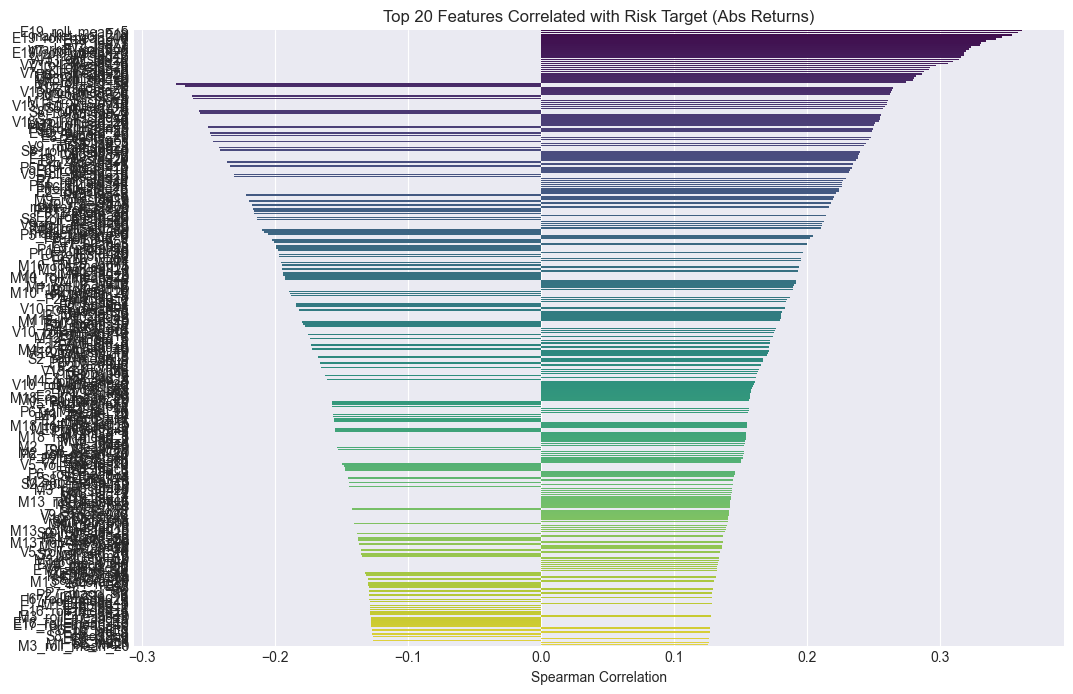

In [5]:
# 상관관계 Bar Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=correlations[top_features].values, y=top_features, palette='viridis')
plt.title('Top 20 Features Correlated with Risk Target (Abs Returns)')
plt.xlabel('Spearman Correlation')
plt.show()


## 5. 산점도 분석
가장 상관관계가 높은 상위 4개 Feature에 대한 산점도를 확인합니다.


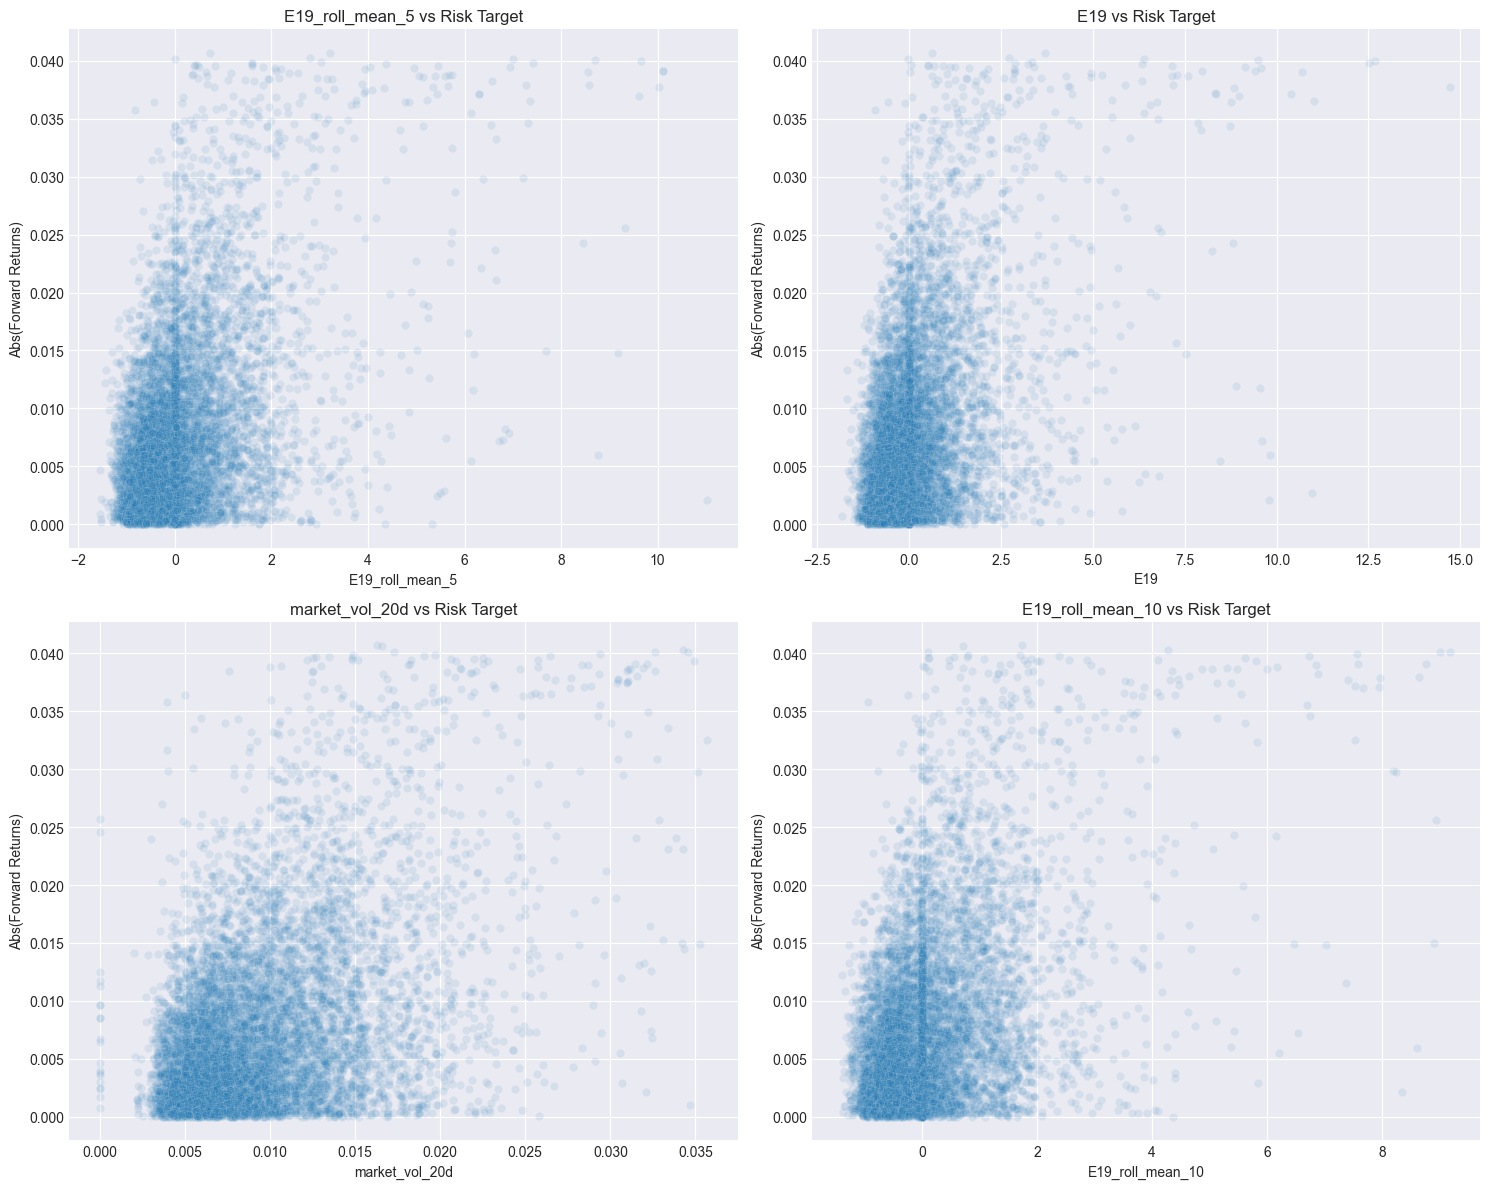

In [6]:
# 상위 4개 Feature 산점도
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(top_features[:4]):
    sns.scatterplot(data=analysis_df, x=feature, y='risk_target', ax=axes[i], alpha=0.1)
    axes[i].set_title(f'{feature} vs Risk Target')
    axes[i].set_ylabel('Abs(Forward Returns)')

plt.tight_layout()
plt.show()


## 6. 결론 및 향후 계획
- 위 분석을 통해 변동성 예측에 유효한 Feature를 식별했습니다.
- Risk Model 학습 시 해당 Feature들을 중점적으로 활용하거나, 추가적인 변동성 지표(예: GARCH, ATR 등)를 도입할지 결정합니다.
